## Login to Huggingface

In [1]:
from dotenv import load_dotenv
import os
from huggingface_hub import login

load_dotenv()
token = os.getenv("HUGGINGFACE_TOKEN")
login(
    token=token, # ADD YOUR TOKEN HERE
    add_to_git_credential=True
)

Token is valid (permission: write).
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /home/pathfinder/.cache/huggingface/token
Login successful


In [2]:
model_name = "bert-finetuned-uncased-QQP"     # ADD YOUR MODEL NAME HERE
username = "PathFinderKR"  # ADD YOUR USERNAME HERE
repo_id = f"{username}/{model_name}"  # repository id

## Login to Weights & Biases

In [3]:
import wandb

api_key = os.getenv("WANDB_API_KEY")
wandb.login(
    key=api_key  # ADD YOUR API KEY HERE
)
wandb.init(project="Quora Question Pairs")

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


## Imports

In [4]:
from IPython.display import display, Markdown

# pytorch
import torch

# huggingface
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)
import evaluate

# datasets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from datasets import Dataset

## Device

In [5]:
# Device setup
device = (
    "cuda:0" if torch.cuda.is_available() else # Nvidia GPU
    "mps" if torch.backends.mps.is_available() else # Apple Silicon GPU
    "cpu"
)
print(f"Device = {device}")

Device = cuda:0


In [6]:
# Flash Attention Implementation
if device == "cuda:0":
    if torch.cuda.get_device_capability()[0] >= 8: # Ampere, Ada, or Hopper GPUs
        attn_implementation = "flash_attention_2"
        torch_dtype = torch.float32
    else:
        attn_implementation = "eager"
        torch_dtype = torch.float32
else:
    attn_implementation = "eager"
    torch_dtype = torch.float32
print(f"Attention Implementation = {attn_implementation}")

Attention Implementation = flash_attention_2


## Hyperparameters

In [7]:
################################################################################
# seed
################################################################################
seed=42
torch.manual_seed(seed)

################################################################################
# Tokenizer parameters
################################################################################
max_length=64
padding="do_not_pad" # "max_length", "longest", "do_not_pad"
truncation=True

################################################################################
# Dataset parameters
################################################################################
validation_size=0.1

################################################################################
# TrainingArguments parameters
################################################################################
output_dir="./results"
logging_dir="./logs"
save_strategy="epoch" # "steps", "epoch"
logging_strategy="steps" # "steps", "epoch"
if logging_strategy == "steps":
    logging_steps=100
else:
    logging_steps=None
evaluation_strategy="steps" # "steps", "epoch"
if evaluation_strategy == "steps":
    eval_steps=100
else:
    eval_steps=None
save_total_limit=1
metric_for_best_model="loss" # "loss", "accuracy", "f1", "precision", "recall"
greater_is_better=False
report_to="wandb"

learning_rate=2e-5
num_train_epochs=1
per_device_train_batch_size=16
per_device_eval_batch_size=64
grad_accumulation_steps=4
optim="adamw_torch" # "sgd", "adamw_torch"
weight_decay=0.1
lr_scheduler_type="cosine" # "constant", "linear", "cosine"
warmup_steps=1000
warmup_ratio=0.1

## Model

In [8]:
# Model ID for base model
model_id = "bert-base-uncased"

In [9]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_id)

In [10]:
# Load model
model = AutoModelForSequenceClassification.from_pretrained(
    model_id,
    num_labels=2,
    device_map=device,
    #attn_implementation="flash_attention_2", # not supported
    torch_dtype=torch_dtype
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
# display the model architecture
display(Markdown(f'```{model}```'))

```BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
          )
          (intermediate): BertIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermediate_act_fn): GELUActivation()
          )
          (output): BertOutput(
            (dense): Linear(in_features=3072, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
      )
    )
    (pooler): BertPooler(
      (dense): Linear(in_features=768, out_features=768, bias=True)
      (activation): Tanh()
    )
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (classifier): Linear(in_features=768, out_features=2, bias=True)
)```

## Dataset

In [12]:
# Dataset Path
dataset_path = "data/"

In [13]:
# Load the dataset
train_df = pd.read_csv(dataset_path + "train.csv")

### Train Dataset

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


Length of the train dataset: 404290

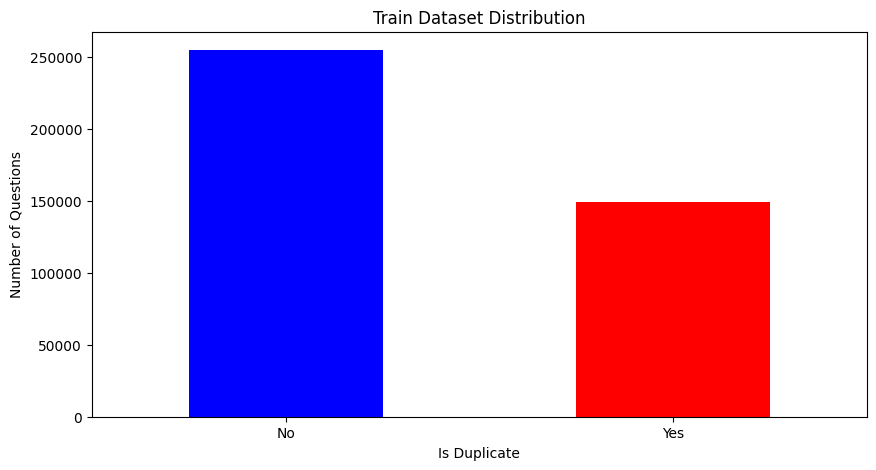

In [14]:
# Train dataset information

# Display the train dataset
display(Markdown("### Train Dataset"))
display(train_df.head())

# Length of the train dataset
display(Markdown(f"Length of the train dataset: {len(train_df)}"))

# Visualize the train dataset distribution
plt.figure(figsize=(10, 5))
train_df["is_duplicate"].value_counts().plot(kind="bar", color=["blue", "red"])
plt.title("Train Dataset Distribution")
plt.xlabel("Is Duplicate")
plt.ylabel("Number of Questions")
plt.xticks([0, 1], ["No", "Yes"], rotation=0)
plt.show()

In [15]:
# Check for missing values

# Number of missing values in train dataset
display(Markdown(f"Number of missing values in train dataset: {train_df.isnull().sum().sum()}"))

# Display the missing values in train dataset
display(Markdown("### Missing Values in Train Dataset"))
display(train_df[train_df.isnull().any(axis=1)])

Number of missing values in train dataset: 3

### Missing Values in Train Dataset

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


Number of duplicated question pairs in train dataset: 0

Number of unique questions in train dataset: 537361

Number of duplicated questions in train dataset: 271219

Number of questions that appear more than once in train dataset: 111872

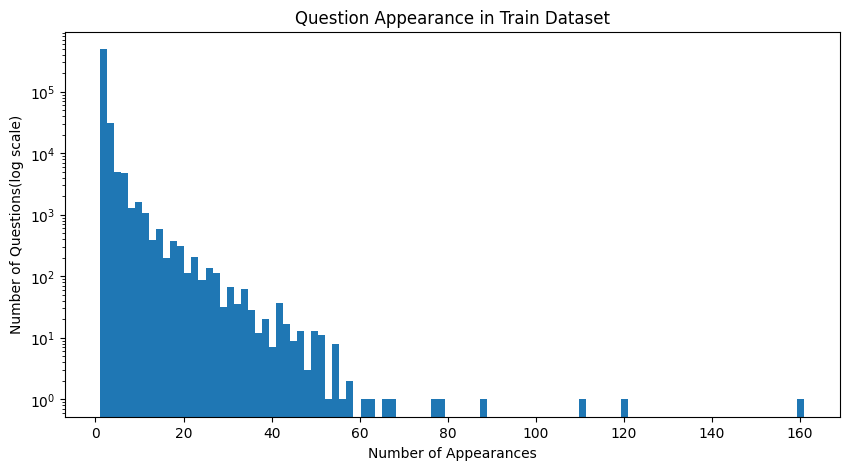

### Statistics of the Questions appearance in Train Dataset

count    537360.000000
mean          1.504721
std           1.911440
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         161.000000
Name: count, dtype: float64

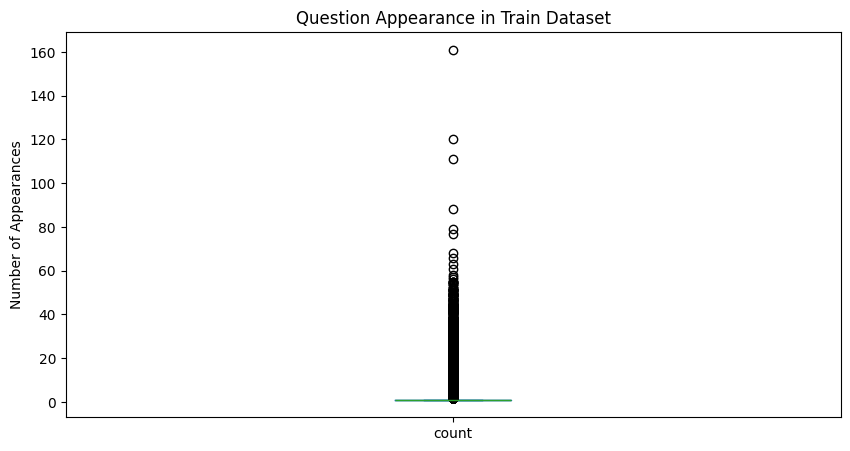

In [16]:
# Check for duplicates

# Number of duplicated question pairs in train dataset
display(Markdown(f"Number of duplicated question pairs in train dataset: {train_df.duplicated(subset=['question1', 'question2']).sum()}"))
# Number of unique questions in train dataset
concatenated_train_df = pd.concat([train_df["question1"], train_df["question2"]])
display(Markdown(f"Number of unique questions in train dataset: {len(concatenated_train_df.unique())}"))
# Number of duplicated questions in train dataset
display(Markdown(f"Number of duplicated questions in train dataset: {len(concatenated_train_df) - len(concatenated_train_df.unique())}"))
# Number of questions that appear more than once in train dataset
display(Markdown(f"Number of questions that appear more than once in train dataset: {np.sum(concatenated_train_df.value_counts() > 1)}"))

# Visualize the question appearance in the train dataset
plt.figure(figsize=(10, 5))
concatenated_train_df.value_counts().plot(kind="hist", bins=100)
plt.title("Question Appearance in Train Dataset")
plt.xlabel("Number of Appearances")
plt.ylabel("Number of Questions(log scale)")
plt.yscale("log")
plt.show()

# Statistics of the question appearance in the train dataset
display(Markdown("### Statistics of the Questions appearance in Train Dataset"))
display(concatenated_train_df.value_counts().describe())

# Visualize the statistics of the questions in the train dataset
plt.figure(figsize=(10, 5))
concatenated_train_df.value_counts().plot(kind="box")
plt.title("Question Appearance in Train Dataset")
plt.ylabel("Number of Appearances")
plt.show()

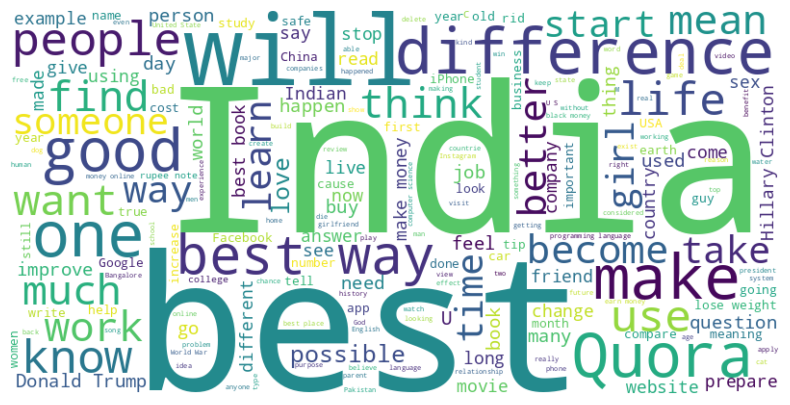

In [17]:
# Visualize the word cloud of the questions in the train dataset
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(" ".join(concatenated_train_df.astype(str).values))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

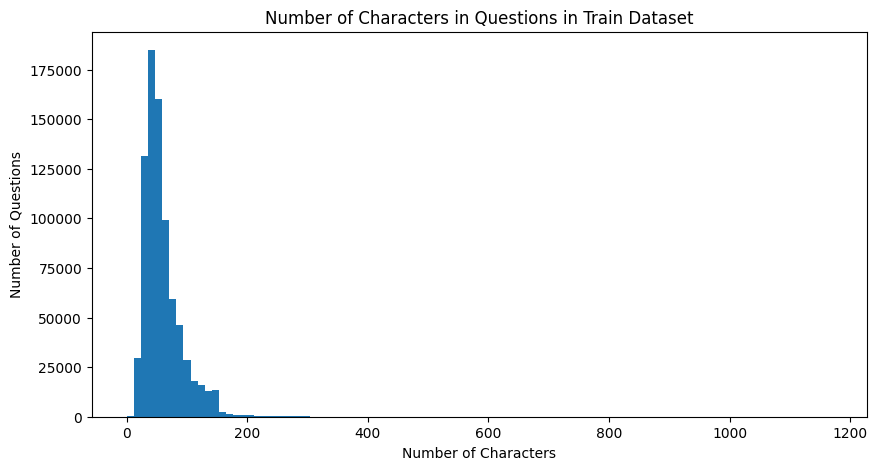

### Statistics of the Number of Characters in Questions in Train Dataset

count    808577.000000
mean         59.822759
std          31.963623
min           1.000000
25%          39.000000
50%          51.000000
75%          72.000000
max        1169.000000
dtype: float64

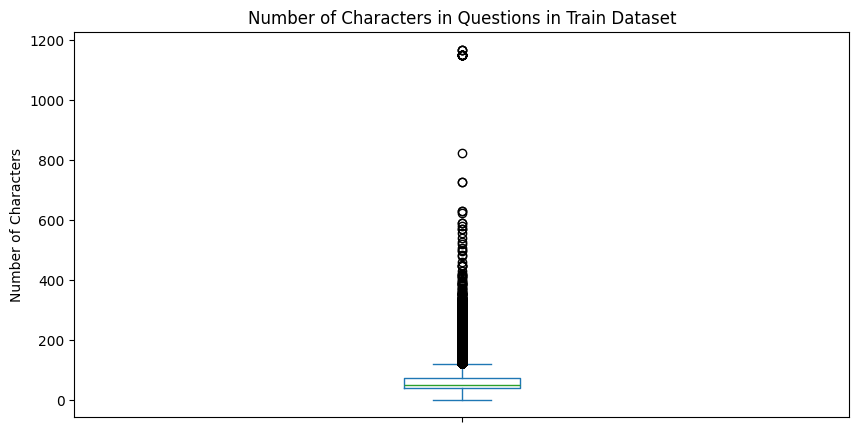

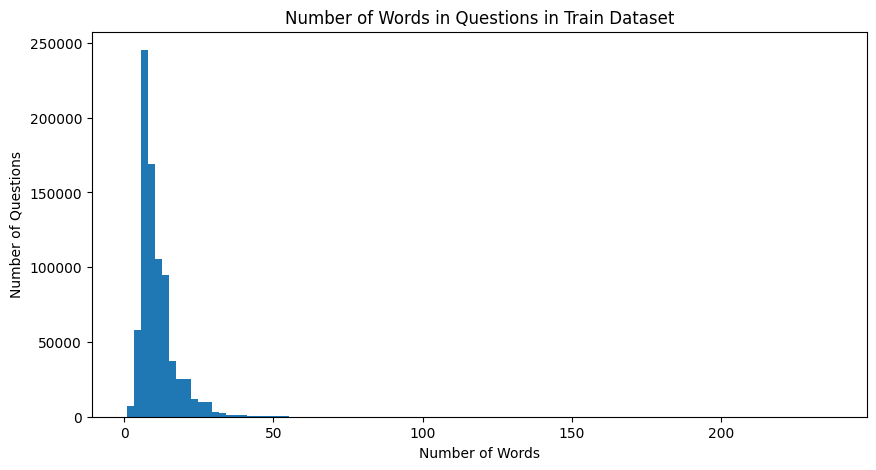

### Statistics of the Number of Words in Questions in Train Dataset

count    808577.000000
mean         11.062138
std           5.884574
min           1.000000
25%           7.000000
50%          10.000000
75%          13.000000
max         237.000000
dtype: float64

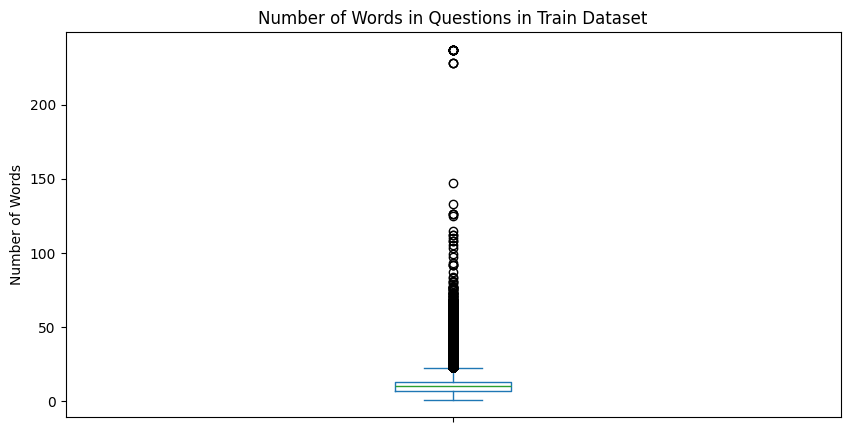

In [18]:
# Character length of the questions in the train dataset

# Visualize the number of characters in the questions in the train dataset
plt.figure(figsize=(10, 5))
concatenated_train_df.str.len().plot(kind="hist", bins=100)
plt.title("Number of Characters in Questions in Train Dataset")
plt.xlabel("Number of Characters")
plt.ylabel("Number of Questions")
plt.show()

# Statistics of the number of characters in the questions in the train dataset
display(Markdown("### Statistics of the Number of Characters in Questions in Train Dataset"))
display(concatenated_train_df.str.len().describe())

# Visualize the statistics of the number of characters in the questions in the train dataset
plt.figure(figsize=(10, 5))
concatenated_train_df.str.len().plot(kind="box")
plt.title("Number of Characters in Questions in Train Dataset")
plt.ylabel("Number of Characters")
plt.show()


# Word length of the questions in the train dataset

# Visualize the number of words in the questions in the train dataset
plt.figure(figsize=(10, 5))
concatenated_train_df.str.split().str.len().plot(kind="hist", bins=100)
plt.title("Number of Words in Questions in Train Dataset")
plt.xlabel("Number of Words")
plt.ylabel("Number of Questions")
plt.show()

# Statistics of the number of words in the questions in the train dataset
display(Markdown("### Statistics of the Number of Words in Questions in Train Dataset"))
display(concatenated_train_df.str.split().str.len().describe())

# Visualize the statistics of the number of words in the questions in the train dataset
plt.figure(figsize=(10, 5))
concatenated_train_df.str.split().str.len().plot(kind="box")
plt.title("Number of Words in Questions in Train Dataset")
plt.ylabel("Number of Words")
plt.show()

## Preprocessing

In [19]:
# 1. Remove missing values

# Number of questions before removing
train_len = len(train_df)
display(Markdown(f"Number of questions before removing: {train_len}"))

# Remove missing values
train_df = train_df.dropna()

# Number of questions after removing
display(Markdown(f"Number of questions after removing: {len(train_df)}"))
# Percentage of questions removed
display(Markdown(f"Percentage of questions removed: {100 * (1 - len(train_df) / train_len):.2f}%"))

Number of questions before removing: 404290

Number of questions after removing: 404287

Percentage of questions removed: 0.00%

Number of questions before removing: 404287

Number of questions after removing: 340219

Percentage of questions removed: 15.85%

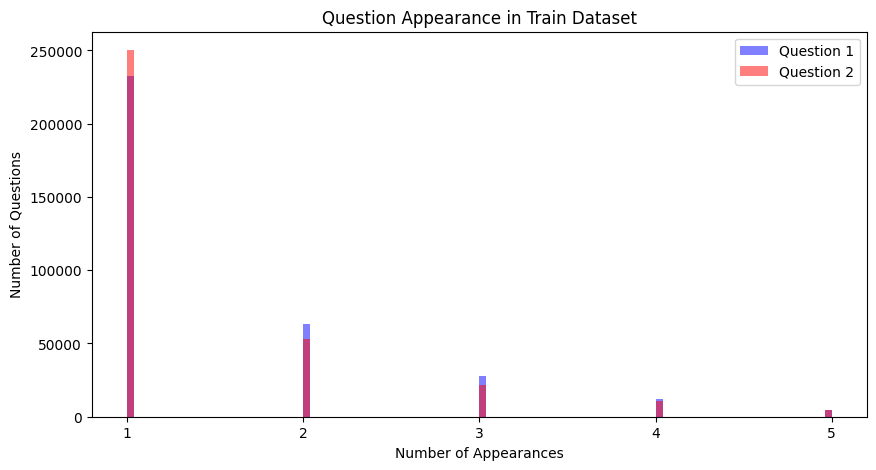

In [20]:
# 2. Remove duplicates

# Number of questions before removing
train_len = len(train_df)
display(Markdown(f"Number of questions before removing: {train_len}"))

# Maximum number of duplicated questions
max_num_duplicates = 5
# Remove questions that are duplicated too many times
train_df = train_df[
    (train_df["question1"].map(train_df["question1"].value_counts()) <= max_num_duplicates) &
    (train_df["question2"].map(train_df["question2"].value_counts()) <= max_num_duplicates)
]

# Number of questions after removing
display(Markdown(f"Number of questions after removing: {len(train_df)}"))
# Percentage of questions removed
display(Markdown(f"Percentage of questions removed: {100 * (1 - len(train_df) / train_len):.2f}%"))

# Visualize the question appearance in the train dataset
plt.figure(figsize=(10, 5))
train_df["question1"].map(train_df["question1"].value_counts()).plot(kind="hist", bins=100, alpha=0.5, color="blue", label="Question 1")
train_df["question2"].map(train_df["question2"].value_counts()).plot(kind="hist", bins=100, alpha=0.5, color="red", label="Question 2")
plt.title("Question Appearance in Train Dataset")
plt.xticks(np.arange(1, max_num_duplicates + 1, 1))
plt.xlabel("Number of Appearances")
plt.ylabel("Number of Questions")
plt.legend()
plt.show()

Number of questions before removing: 340219

Number of questions after removing: 334604

Percentage of questions removed: 0.00%

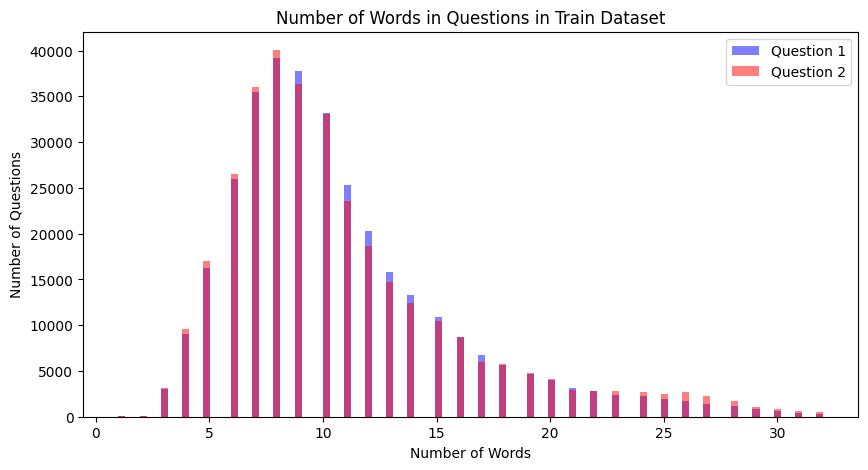

In [21]:
# 3. Remove questions that have too many words

# Number of questions before removing
train_len = len(train_df)
display(Markdown(f"Number of questions before removing: {train_len}"))

# Maximum number of words in the questions
max_num_words = 32
# Remove questions that have too many words
train_df_3 = train_df[
    (train_df["question1"].str.split().str.len() <= max_num_words) &
    (train_df["question2"].str.split().str.len() <= max_num_words)
]

# Number of questions after removing
display(Markdown(f"Number of questions after removing: {len(train_df_3)}"))
# Percentage of questions removed
display(Markdown(f"Percentage of questions removed: {100 * (1 - len(train_df) / train_len):.2f}%"))

# Visualize the number of words in the questions in the train dataset
plt.figure(figsize=(10, 5))
train_df_3["question1"].str.split().str.len().plot(kind="hist", bins=100, alpha=0.5, color="blue", label="Question 1")
train_df_3["question2"].str.split().str.len().plot(kind="hist", bins=100, alpha=0.5, color="red", label="Question 2")
plt.title("Number of Words in Questions in Train Dataset")
plt.xlabel("Number of Words")
plt.ylabel("Number of Questions")
plt.legend()
plt.show()

Number of questions before removing: 340219

Number of question pairs to remove: 135665

Number of questions after removing: 204554

Percentage of questions removed: 39.88%

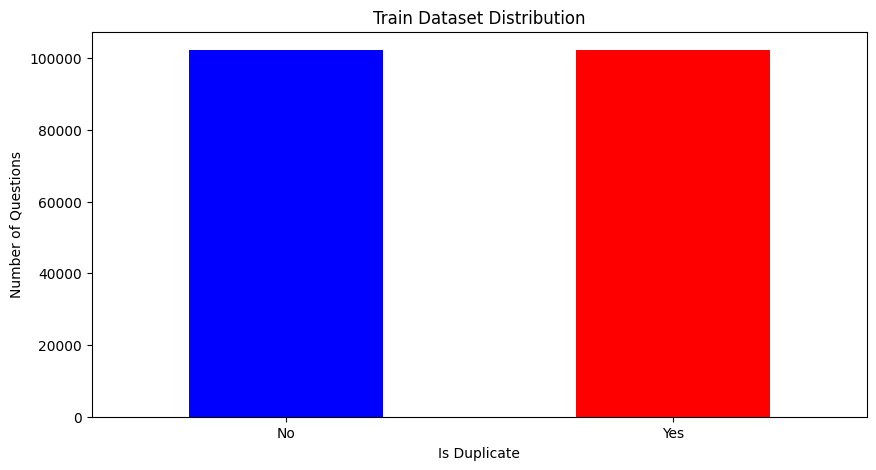

In [22]:
# 4. Balance "is_duplicate" classes

# Number of questions before removing
train_len = len(train_df)
display(Markdown(f"Number of questions before removing: {train_len}"))

# Number of questions to remove
num_question_pairs_to_remove = train_df["is_duplicate"].value_counts()[0] - train_df["is_duplicate"].value_counts()[1]
display(Markdown(f"Number of question pairs to remove: {num_question_pairs_to_remove}"))

# Remove questions to balance "is_duplicate" classes
train_df = train_df.drop(train_df_3[train_df_3["is_duplicate"] == 0].sample(n=num_question_pairs_to_remove, random_state=seed).index)

# Number of questions after removing
display(Markdown(f"Number of questions after removing: {len(train_df)}"))
# Percentage of questions removed
display(Markdown(f"Percentage of questions removed: {100 * (1 - len(train_df) / train_len):.2f}%"))

# Check the distribution of "is_duplicate" classes
plt.figure(figsize=(10, 5))
train_df["is_duplicate"].value_counts().plot(kind="bar", color=["blue", "red"])
plt.title("Train Dataset Distribution")
plt.xlabel("Is Duplicate")
plt.ylabel("Number of Questions")
plt.xticks([0, 1], ["No", "Yes"], rotation=0)
plt.show()

In [23]:
# 5. Tokenize the questions

# convert dataframe into huggingface dataset
dataset = Dataset.from_pandas(train_df)

def tokenize_function(example):
    encoding = tokenizer(
        example["question1"],
        example["question2"],
        max_length=max_length,
        padding=padding,
        truncation=truncation
    )
    encoding["labels"] = example["is_duplicate"]
    return encoding

dataset = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/204554 [00:00<?, ? examples/s]

In [24]:
# 6. train-validation split

# split the dataset into train and validation
dataset = dataset.train_test_split(test_size=validation_size, seed=seed)

# Number of questions in the train, validation dataset
display(Markdown(f"Number of questions in the train dataset: {len(dataset['train'])}"))
display(Markdown(f"Number of questions in the validation dataset: {len(dataset['test'])}"))

Number of questions in the train dataset: 184098

Number of questions in the validation dataset: 20456

In [25]:
# Dataset example
print(dataset["train"][0])

{'id': 299337, 'qid1': 49882, 'qid2': 157989, 'question1': 'How can stress cause you to lose weight?', 'question2': 'Can you explain in detail the relation between stress and gain or lose of weight?', 'is_duplicate': 1, '__index_level_0__': 299337, 'input_ids': [101, 2129, 2064, 6911, 3426, 2017, 2000, 4558, 3635, 1029, 102, 2064, 2017, 4863, 1999, 6987, 1996, 7189, 2090, 6911, 1998, 5114, 2030, 4558, 1997, 3635, 1029, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'labels': 1}


## Inference before Fine-Tuning

In [26]:
def predict(question1, question2):
    inputs = tokenizer(question1, question2, return_tensors="pt")
    inputs = {name: tensor.to(model.device) for name, tensor in inputs.items()}
    outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=-1)
    return {
        "probabilities": probabilities.detach().cpu().numpy(),
        "is_duplicate": bool(torch.argmax(probabilities) == 1)
    }

In [27]:
question1 = dataset["test"][0]["question1"]
question2 = dataset["test"][0]["question2"]
print(f"Question 1: {question1}")
print(f"Question 2: {question2}")

Question 1: Why is it so expensive to get dress pants hemmed in NYC?
Question 2: Can I wear a black jacket with grey dress pants and a dark blue shirt to a political event? Or is it to preppy?


In [28]:
predict(question1, question2)

{'probabilities': array([[0.4055789, 0.5944211]], dtype=float32),
 'is_duplicate': True}

## Fine-tuning

In [29]:
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, is_duplicate = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=is_duplicate)

In [30]:
training_args = TrainingArguments(
    output_dir=output_dir,
    logging_dir=logging_dir,
    save_strategy=save_strategy,
    logging_strategy=logging_strategy,
    logging_steps=logging_steps,
    evaluation_strategy=evaluation_strategy,
    eval_steps=eval_steps,
    save_total_limit=save_total_limit,
    metric_for_best_model=metric_for_best_model,
    greater_is_better=greater_is_better,
    report_to=report_to,
    
    learning_rate=learning_rate,
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=per_device_train_batch_size,
    per_device_eval_batch_size=per_device_eval_batch_size,
    gradient_accumulation_steps=grad_accumulation_steps,
    weight_decay=weight_decay,
    lr_scheduler_type=lr_scheduler_type,
    warmup_steps=warmup_steps,
    warmup_ratio=warmup_ratio,
    seed=seed
)

In [31]:
trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    compute_metrics=compute_metrics
)

In [32]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy
100,0.693800,0.651115,0.668606
200,0.598500,0.518177,0.771021
300,0.484400,0.452966,0.786615
400,0.444700,0.407578,0.815653
500,0.411400,0.395388,0.825724
600,0.390600,0.381833,0.834865
700,0.376300,0.362152,0.843176
800,0.377000,0.366140,0.840340
900,0.363700,0.345277,0.848700
1000,0.351300,0.360133,0.849433


TrainOutput(global_step=2876, training_loss=0.36560158802504666, metrics={'train_runtime': 784.4413, 'train_samples_per_second': 234.687, 'train_steps_per_second': 3.666, 'total_flos': 5277547326174720.0, 'train_loss': 0.36560158802504666, 'epoch': 0.9997392891283566})

In [33]:
wandb.finish()
trainer.save_model(model_name)

eval/accuracy,▁▄▅▆▆▇▇▇▇▇▇▇▇███████████████
eval/loss,█▅▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/runtime,▆▇▇█████▄▁▁▁▁▁▂▂▁▂▂▂▃▂▂▂▂▂▂▂
eval/samples_per_second,▃▂▂▁▁▁▁▁▅█████▇▇█▇▇▇▆▇▇▇▇▇▇▇
eval/steps_per_second,▃▂▂▁▁▁▁▁▅█████▇▇█▇▇▇▆▇▇▇▇▇▇▇
train/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/grad_norm,▁▃▅▆▄▅▃▆▄▆▃▄▅▃▅▃█▅▃▄▄▄▆▄▄▃▄▄
train/learning_rate,▂▂▃▄▄▅▆▇▇████▇▇▆▆▅▅▄▄▃▂▂▂▁▁▁
train/loss,█▆▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁
eval/accuracy,0.87652


## Inference after Fine-tuning

In [34]:
predict(question1, question2)

{'probabilities': array([[0.99708086, 0.00291908]], dtype=float32),
 'is_duplicate': False}

## Compare to Sentence Similarity

In [35]:
from sentence_transformers import SentenceTransformer, util

sentence_transformer = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

In [36]:
def sentence_similarity(question1, question2):
    embeddings1 = sentence_transformer.encode(question1, convert_to_tensor=True)
    embeddings2 = sentence_transformer.encode(question2, convert_to_tensor=True)
    cosine_score = util.pytorch_cos_sim(embeddings1, embeddings2)
    return {
        "cosine_similarity": cosine_score.item(),
        "is_duplicate": bool(cosine_score > 0.7)
    }

In [37]:
sentence_similarity(question1, question2)

{'cosine_similarity': 0.33640164136886597, 'is_duplicate': False}

## Upload Model

In [38]:
# Push model and tokenizer to Hugging Face Hub
model.push_to_hub(
    repo_id=repo_id,
    use_temp_dir=False
)
tokenizer.push_to_hub(
    repo_id=repo_id,
    use_temp_dir=False
)

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/PathFinderKR/bert-finetuned-uncased-QQP/commit/948c5534d6174c1589c41dfffda08152292228f5', commit_message='Upload tokenizer', commit_description='', oid='948c5534d6174c1589c41dfffda08152292228f5', pr_url=None, pr_revision=None, pr_num=None)